In [1]:
import numpy as np
import pandas as pd

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

In [3]:
from transformers import AutoTokenizer, TFBertModel

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

In [5]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [6]:
# loading data
train_data = pd.read_csv('train.csv', usecols=['id', 'text', 'target'])
test_data = pd.read_csv('test.csv', usecols=['id', 'text'])
sample_data = pd.read_csv('sample_submission.csv')

In [7]:
train_data.shape

(7613, 3)

In [8]:
# Data Preprocessing
stop_words = set(stopwords.words('english'))

In [9]:
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [10]:
train_data

,id,text,target
0,1,Our Deeds Reason #earthquake May ALLAH Forgive us,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked 'shelter place' notified o...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent photo Ruby #Alaska smoke #wildfi...,1
...,...,...,...
7608,10869,Two giant cranes holding bridge collapse nearb...,1
7609,10870,@aria_ahrary @TheTawniest The control wild fir...,1
7610,10871,M1.94 [01:04 UTC]?5km S Volcano Hawaii. http:/...,1
7611,10872,Police investigating e-bike collided car Littl...,1


In [11]:
# overview of the words frequently appears in the "true disaster tweet" 
disaster_tweets = train_data[train_data.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)

In [12]:
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')

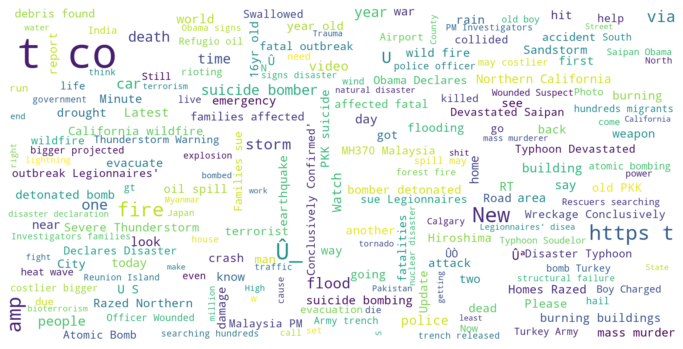

In [13]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# overview of the words frequently appears in the "non-disaster tweet" 
formal_tweets = train_data[train_data.target == 0]

In [15]:
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')

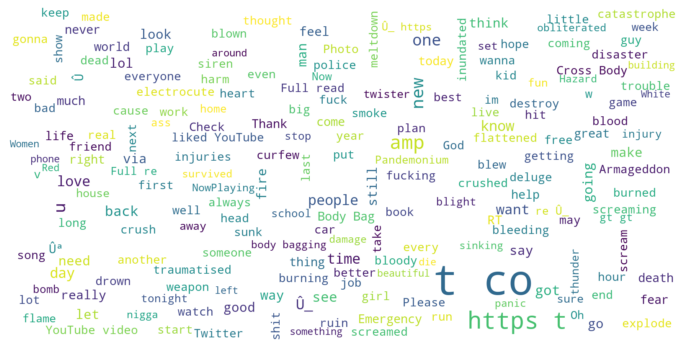

In [16]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=100, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

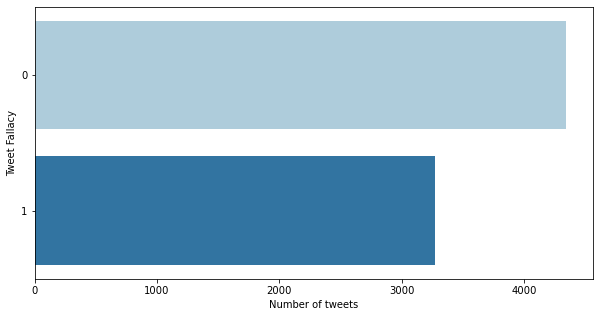

In [19]:
# visualizing class distribution
plt.figure(figsize=(10,5))
sns.countplot(y='target', data=train_data, palette='Paired')
plt.ylabel('Tweet Fallacy')
plt.xlabel('Number of tweets')
plt.show()

In [21]:
# load the BERT model
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

In [22]:
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
# testing tokenizer
tokenizer('Happy learning and keep kaggling &*&*&&')

{'input_ids': [101, 3407, 4083, 1998, 2562, 10556, 13871, 2989, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [31]:
# conversion of text data into BERT input format
print("max len of tweets", max([len(x.split()) for x in train_data.text]))
max_len = 36

max len of tweets 28


In [25]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_attention_mask=True,
    verbose=True,
    )

In [26]:
x_train

{'input_ids': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  1012, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [27]:
y_train = train_data.target.values

In [28]:
y_train

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [29]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [32]:
# building model architecture
import tensorflow as tf
input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

In [33]:
embeddings = bert(input_ids, attention_mask = input_mask)[1]

In [35]:
out = tf.keras.layers.Dropout(0.1)(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

In [36]:
y = Dense(1, activation='sigmoid')(out)

In [37]:
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                            

In [39]:
optimizer = Adam(
    learning_rate=6e-6,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

In [40]:
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy')

In [41]:
model.compile(optimizer = optimizer,
              loss = loss,
              metrics = metric)

In [ ]:
final = model.fit(x = {'input_ids': x_train['input_ids'],
                       'attention_mask': x_train['attention_mask']},
                 y = y_train,
                 epochs=1,
                 batch_size=10)

C:\Users\dougl\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


604/762 [======================>.......] - ETA: 13:16 - loss: 0.4906 - accuracy: 0.7826

In [43]:
test_data

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,Storm in RI worse than last hurricane. My city...
3260,10868,Green Line derailment in Chicago http://t.co/U...
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...


In [44]:
x_test = tokenizer(
    text=test_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask=True,
    verbose=True,
    )

In [45]:
x_test

{'input_ids': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[  101,  2074,  3047, ...,     0,     0,     0],
       [  101,  2657,  2055, ...,     0,     0,     0],
       [  101,  2045,  2003, ...,     0,     0,     0],
       ...,
       [  101,  2665,  2240, ...,     0,     0,     0],
       [  101, 12669,  3314, ...,     0,     0,     0],
       [  101,  1001,  2103, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(3263, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [81]:
# Prediction:
predicted = model.predict({'input_ids': x_test['input_ids'], 
                           'attention_mask': x_test['attention_mask']})

In [82]:
y_predicted = np.where(predicted > 0.5, 1, 0)

In [86]:
y_predicted = y_predicted.reshape((1, 3263))[0]

In [88]:
sample_data['id'] = test_data.id
sample_data['target'] = y_predicted

In [89]:
sample_data.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1


In [90]:
sample_data.to_csv('submission.csv', index=False)
print('Successfully completed!')

Successfully completed!
